## Assignment 4
CE 260: Air Transportation  
Paul Sohn  
5/3/2016

In [1]:
% matplotlib inline
import numpy as np, pandas as pd, matplotlib
from matplotlib import pyplot as plt

## Data Preparation
The first steps before we get started on the problems are:
* Bring in the schedule data and subset to the time period we are interested in (7am to 12pm)
* Calculate the probabilities of various types of aircraft
* Bring in performance data
* Copy IFR and VFR separation standards from lecture slides and Table 1

In [2]:
# Import schedule

sched = pd.read_csv("schedule.csv")

# Subset to between 7am and 12pm

print(len(sched))    # check counts before
sc = sched[(sched["Arrival Time 2"] >= 7) & (sched["Arrival Time 2"] <= 12)]
print(len(sc))    # check counts after

1001
306


In [3]:
# Add performance data to schedule 

pf = pd.read_csv("performance.csv") # Read in performance dataset
sc = sc.merge(pf,on="EQP",how="left") # Merge performance variables into schedule

In [4]:
# Check the schedule dataset

sc.head()

,CAR,FLNO,EQP,SEATS,ORIGIN,Arrival Time 2,Arrival Time 1,MTOW (000 lbs),ASPEEDF (kts),TYPE,Class
0,A1,3319,SF3,33,SBP,7.08,7:05,29.0,120,Saab A340,L
1,A1,3286,SF3,33,FAT,7.25,7:15,29.0,120,Saab A340,L
2,A1,3345,SF3,33,MRY,7.25,7:15,29.0,120,Saab A340,L
3,A1,3212,SF3,33,SAN,7.50,7:30,29.0,120,Saab A340,L
4,A1,3386,SF3,33,CLD,7.50,7:30,29.0,120,Saab A340,L


In [5]:
# Check the performance dataset

pf.head()

,EQP,MTOW (000 lbs),ASPEEDF (kts),TYPE,Class
0,EM2,25.4,113,Embraer 120,S
1,J31,16.0,112,Jetstream Super31,S
2,146,95.0,121,BAe 146,L
3,319,141.1,139,Airbus 319,L
4,320,162.0,139,Airbus 320,L


In [6]:
# Assign Boeing 757 as different class in schedule and performance datasets

sc["Class"][sc.TYPE == "Boeing 757"] = "B"
pf["Class"][pf.TYPE == "Boeing 757"] = "B"

C:\Users\pksohn\Anaconda\envs\ipykernel_py3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\pksohn\Anaconda\envs\ipykernel_py3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [7]:
# Calculate probabilities of different classes in time subset

probs = sc.groupby("Class").count()["TYPE"] / len(sc)
probs

Class
B    0.078431
H    0.153595
L    0.480392
S    0.287582
Name: TYPE, dtype: float64

In [8]:
# Create a starting dataframe with all combinations of lead and trail aircraft

lead = probs.index.tolist() * 4
trail = (probs.index.tolist() * 4)
trail.sort()

ref = pd.DataFrame(data=[lead,trail], index=["lead","trail"] ).T

In [9]:
# Add IFR and VFR separation standards

# IMPORTANT! 
# IFR IS IN MINUTES
# VFR IS IN NAUTICAL MILES

sp = pd.read_csv("separation.csv")
ref = ref.merge(sp,on=["lead","trail"],how="left")

In [10]:
ref

,lead,trail,ifr,vfr
0,B,B,2.00,3.6
1,H,B,2.50,3.6
2,L,B,1.25,1.9
3,S,B,1.25,1.9
4,B,H,2.00,2.7
5,H,H,2.00,2.7
6,L,H,1.25,1.9
7,S,H,1.25,1.9
8,B,L,2.00,2.9
9,H,L,2.50,3.6


In [11]:
# Calculate joint probabilities

def joint(row):
    
    p_lead = probs[row["lead"]]
    p_trail = probs[row["trail"]]
    
    return p_lead * p_trail

ref["joint"] = ref.apply(joint, axis = 1)

In [12]:
ref

,lead,trail,ifr,vfr,joint
0,B,B,2.00,3.6,0.006151
1,H,B,2.50,3.6,0.012047
2,L,B,1.25,1.9,0.037678
3,S,B,1.25,1.9,0.022555
4,B,H,2.00,2.7,0.012047
5,H,H,2.00,2.7,0.023591
6,L,H,1.25,1.9,0.073786
7,S,H,1.25,1.9,0.044171
8,B,L,2.00,2.9,0.037678
9,H,L,2.50,3.6,0.073786


## Question 1

>Estimate the IFR arrival capacity of a single runway at LAX under the following
>assumptions:
>* There is a 10nm final approach path; separations rules apply once both aircraft are on the flight path.
>* The aircraft mix is based on flights scheduled to arrive between 7am and 12 noon.
>* The order of arrival is random so that the probability of an aircraft of type i trailing an aircraft of type j is: ij i j P = >P ⋅ P .
>* A 30 second buffer is added to the minimum IFR inter-arrival times to ensure that minima are not violated.

I drop the VFR separation requirements to begin the dataframe for this problem:

In [13]:
q1 = ref.drop("vfr",axis=1)
q1

,lead,trail,ifr,joint
0,B,B,2.00,0.006151
1,H,B,2.50,0.012047
2,L,B,1.25,0.037678
3,S,B,1.25,0.022555
4,B,H,2.00,0.012047
5,H,H,2.00,0.023591
6,L,H,1.25,0.073786
7,S,H,1.25,0.044171
8,B,L,2.00,0.037678
9,H,L,2.50,0.073786


The joint probabilities are already calculated, so I now just need to aggregate the probabilities with separation time according to the formula:

$$
\text{Capacity} = \frac{60}{\sum_{\alpha' \alpha} p_{\alpha' \alpha} \tau_{\alpha' \alpha}}
$$ 

I also add 30 seconds (0.5 minutes) to IFR time in each case in order to take the buffer into account.

In [14]:
q1["pt"] = (q1.ifr + 0.5) * q1.joint
q1

,lead,trail,ifr,joint,pt
0,B,B,2.00,0.006151,0.015379
1,H,B,2.50,0.012047,0.036140
2,L,B,1.25,0.037678,0.065936
3,S,B,1.25,0.022555,0.039472
4,B,H,2.00,0.012047,0.030117
5,H,H,2.00,0.023591,0.058978
6,L,H,1.25,0.073786,0.129125
7,S,H,1.25,0.044171,0.077299
8,B,L,2.00,0.037678,0.094195
9,H,L,2.50,0.073786,0.221357


### Q1 Results

In [15]:
q1_capacity = 60 / q1.pt.sum()
print("Capacity for question 1 is:", "{:.2f}".format(q1_capacity), "aircraft per hour")

Capacity for question 1 is: 28.22 aircraft per hour


## Question 2

> Repeat 1 using observed VFR separations (in NM) given in Table 1. In this case neglect buffers and assume that the separations > are derived from observations when the lead aircraft crosses the runway threshold.

The first thing I have to do in this problem is find aircraft speeds in order to convert the VFR separation standards into time units (i.e. minutes). One simple approximation is to use average speeds for different types of aircraft. We will apply this to the trailing aircraft, since we are observing separation at the time when the lead aircraft hits the runway.

In [16]:
# Get mean speeds by aircraft class

speeds = pf.groupby("Class").mean()["ASPEEDF (kts)"]
speeds

Class
B    139.000000
H    143.571429
L    135.850000
S    112.500000
Name: ASPEEDF (kts), dtype: float64

In [17]:
# Join to calculation dataframe
q2 = ref.join(speeds,on="trail")

# Also, drop IFR columns for the purpose of this question
q2 = q2.drop("ifr",axis = 1)

In [18]:
q2

,lead,trail,vfr,joint,ASPEEDF (kts)
0,B,B,3.6,0.006151,139.000000
1,H,B,3.6,0.012047,139.000000
2,L,B,1.9,0.037678,139.000000
3,S,B,1.9,0.022555,139.000000
4,B,H,2.7,0.012047,143.571429
5,H,H,2.7,0.023591,143.571429
6,L,H,1.9,0.073786,143.571429
7,S,H,1.9,0.044171,143.571429
8,B,L,2.9,0.037678,135.850000
9,H,L,3.6,0.073786,135.850000


Now I recalculate VFR into minutes using distance and speed:

$$
VFR_{minutes} = \frac{VFR_{nmi}}{SPEED_{knots}} * 60 
$$

In [19]:
q2["vfr_min"] = (q2.vfr / q2["ASPEEDF (kts)"]) * 60
q2

,lead,trail,vfr,joint,ASPEEDF (kts),vfr_min
0,B,B,3.6,0.006151,139.000000,1.553957
1,H,B,3.6,0.012047,139.000000,1.553957
2,L,B,1.9,0.037678,139.000000,0.820144
3,S,B,1.9,0.022555,139.000000,0.820144
4,B,H,2.7,0.012047,143.571429,1.128358
5,H,H,2.7,0.023591,143.571429,1.128358
6,L,H,1.9,0.073786,143.571429,0.794030
7,S,H,1.9,0.044171,143.571429,0.794030
8,B,L,2.9,0.037678,135.850000,1.280824
9,H,L,3.6,0.073786,135.850000,1.589989


### Q2 Results

Since there is no buffer, I now aggregate using the same formula:

In [20]:
q2["pt"] = (q2.vfr_min) * q2.joint
q2_capacity = 60 / q2.pt.sum()
print("Capacity for question 2 is:", "{:.2f}".format(q2_capacity), "aircraft per hour")

Capacity for question 2 is: 53.57 aircraft per hour


## Question 3

> Repeat 2, but assume that TRACON controllers add a 15-second buffer in feeding traffic to LAX because of terminal airspace constraints.

This is simple: I will just add 15 seconds (.25 minutes) to each VFR separation time.

In [21]:
q3 = q2.copy()

# Add .25 minutes to VFR time
q3["vfr_min"] = (q3.vfr / q3["ASPEEDF (kts)"]) * 60 + .25

# Recalculate p*t and capacity
q3["pt"] = (q3.vfr_min) * q3.joint
q3_capacity = 60 / q3.pt.sum()
print("Capacity for question 3 is:", "{:.2f}".format(q3_capacity), "aircraft per hour")

Capacity for question 3 is: 43.80 aircraft per hour


## Question 4

>LAX operates two independent parallel runways under IFR. Estimate the total delay and average delay per flight for all flights scheduled to arrive between 7 am and 12 noon.

In [22]:
q4 = sc.sort_values("Arrival Time 2").reset_index()

In [23]:
# View first five sorted entries in schedule

q4.head()

,index,CAR,FLNO,EQP,SEATS,ORIGIN,Arrival Time 2,Arrival Time 1,MTOW (000 lbs),ASPEEDF (kts),TYPE,Class
0,213,UA3,5364,EM2,30,IPL,7.0,7:00,25.4,113,Embraer 120,S
1,149,RG,832,743,398,LIM,7.0,7:00,775.5,141,Boeing 747 1,H
2,101,OE,7302,J31,18,IYK,7.0,7:00,16.0,112,Jetstream Super31,S
3,214,UA3,5000,EM2,30,SBP,7.0,7:00,25.4,113,Embraer 120,S
4,215,UA3,5122,EM2,30,SBA,7.0,7:00,25.4,113,Embraer 120,S


In [24]:
# View last five sorted entries in schedule

q4.tail()

,index,CAR,FLNO,EQP,SEATS,ORIGIN,Arrival Time 2,Arrival Time 1,MTOW (000 lbs),ASPEEDF (kts),TYPE,Class
301,136,OO,5533,EM2,30,FAT,12.0,12:00,25.4,113,Embraer 120,S
302,212,UA,875,762,204,BOS,12.0,12:00,300.0,143,Boeing 767,H
303,137,OO,5683,EM2,30,PSP,12.0,12:00,25.4,113,Embraer 120,S
304,35,AA,11,767,189,BOS,12.0,12:00,300.0,143,Boeing 767,H
305,138,OO,5638,EM2,30,SBA,12.0,12:00,25.4,113,Embraer 120,S


I assume that given the dual runway setup, arriving aircraft will alternate runways. Therefore, in the sorted schedule above, an aircraft will land following the aircraft two rows above it in the schedule.  

In [25]:
q4.head()

,index,CAR,FLNO,EQP,SEATS,ORIGIN,Arrival Time 2,Arrival Time 1,MTOW (000 lbs),ASPEEDF (kts),TYPE,Class
0,213,UA3,5364,EM2,30,IPL,7.0,7:00,25.4,113,Embraer 120,S
1,149,RG,832,743,398,LIM,7.0,7:00,775.5,141,Boeing 747 1,H
2,101,OE,7302,J31,18,IYK,7.0,7:00,16.0,112,Jetstream Super31,S
3,214,UA3,5000,EM2,30,SBP,7.0,7:00,25.4,113,Embraer 120,S
4,215,UA3,5122,EM2,30,SBA,7.0,7:00,25.4,113,Embraer 120,S


In [26]:
def calc_schedule(df):
    
    # create a new column for actual arrival time
    df["arrival_actual"] = 0.0
    
    # assign flights to runways
    df["index_val"] = df.index
    df["runway"] = df.apply(lambda row: 1 if row.index_val % 2 == 0 else 2, axis = 1)
    df = df.drop("index_val", axis = 1)
    
    # prepare first two arrivals
    df.loc[0, "arrival_actual"] = df.loc[0, "Arrival Time 2"]
    df.loc[1, "arrival_actual"] = df.loc[1, "Arrival Time 2"]
    
    # loop through all arrivals to runway 1
    for i in df.index.values:
        if (df.runway[i] == 1) & (i > 1):
            
            prev = max(i-2,i-4)
            
            # get actual arrival time of previous arrival
            lead_time = df.arrival_actual[prev]
            
            # get lead and trailing aircraft class
            lead_class = df.Class[prev]
            trail_class = df.Class[i]
            
            # get separation time from reference table, add 30 seconds of buffer, convert to hours
            separation = (ref[(ref.lead == lead_class) & (ref.trail == trail_class)]["ifr"].values[0] + .5) / 60
            
            # assign arrival time based on minimum separation 
            df.arrival_actual[i] = max(lead_time + separation, df["Arrival Time 2"][i])
    
    # repeat above steps for runway 2
        elif (df.runway[i] == 2) & (i > 1):
            prev = max(i-2,i-4)
            lead_time = df.arrival_actual[prev]
            lead_class = df.Class[prev]
            trail_class = df.Class[i]
            separation = (ref[(ref.lead == lead_class) & (ref.trail == trail_class)]["ifr"].values[0] + .5) / 60 
            df.arrival_actual[i] = max(lead_time + separation, df["Arrival Time 2"][i])
    
    # calculate delay for each aircraft
    df["delay"] = round(df.arrival_actual - df["Arrival Time 2"],4)
    
    return df

In [27]:
# run the function above on our schedule for Q4

q4 = calc_schedule(q4)

C:\Users\pksohn\Anaconda\envs\ipykernel_py3\lib\site-packages\ipykernel\__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\pksohn\Anaconda\envs\ipykernel_py3\lib\site-packages\ipykernel\__main__.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Q4 Results

In [28]:
print("The total delay for this schedule between 7am and 12pm is", q4.delay.sum(), "hours")
print("The mean delay for this schedule between 7am and 12pm is", q4.delay.mean(), "hours")

The total delay for this schedule between 7am and 12pm is 106.2382 hours
The mean delay for this schedule between 7am and 12pm is 0.347183660131 hours


## Question 5

> Estimate the incremental delay, under IFR, resulting from US3 flight 4759 under IFR. Again consider only flights scheduled to arrive between 7 am and 12 noon.

I estimate the delay from including this flight by removing it from the schedule, checking the total delay, and comparing from before.

In [29]:
# get and sort schedule

q5 = sc.sort_values("Arrival Time 2")

# Find the row that has this flight

q5[q5.FLNO == 4759]

,CAR,FLNO,EQP,SEATS,ORIGIN,Arrival Time 2,Arrival Time 1,MTOW (000 lbs),ASPEEDF (kts),TYPE,Class
263,US3,4759,J31,18,SAN,10.83,10:50,16.0,112,Jetstream Super31,S


In [30]:
# drop this row

print(len(q5))
q5 = q5.drop(263)
print(len(q5))

# reindex
q5 = q5.reset_index()

306
305


In [31]:
# run the schedule generation and delay calculation 

q5 = calc_schedule(q5)
print("The total delay for this schedule between 7am and 12pm is", q5.delay.sum(), "hours")
print("The mean delay for this schedule between 7am and 12pm is", q5.delay.mean(), "hours")

C:\Users\pksohn\Anaconda\envs\ipykernel_py3\lib\site-packages\ipykernel\__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\pksohn\Anaconda\envs\ipykernel_py3\lib\site-packages\ipykernel\__main__.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


The total delay for this schedule between 7am and 12pm is 103.8842 hours
The mean delay for this schedule between 7am and 12pm is 0.340603934426 hours


### Q5 Results

The total delay for the full schedule was 106.2382 hours. When flight 4659 was removed, the total delay was 103.8842 hours. The difference is 2.35 hours, which is the incremental delay of that flight.

## Question 6
> Estimate how the IFR delay at LAX would change if demand grew 20%. Again consider only flights scheduled to arrive between 7 am and 12 noon.

For this question, I will add flights evenly spaced between 7am and 12pm, and recalculate demand. 

In [32]:
# What is 20% of demand?

print (len(sc) * 0.2, "flights")

61.2 flights


In [33]:
# Evenly space 61 flights between 7 and 12
new_headway = (12-7) / 61
new_times = np.arange(start = 7, stop = 12, step = new_headway)

# show newly generated times
print(new_times)

[  7.           7.08196721   7.16393443   7.24590164   7.32786885
   7.40983607   7.49180328   7.57377049   7.6557377    7.73770492
   7.81967213   7.90163934   7.98360656   8.06557377   8.14754098
   8.2295082    8.31147541   8.39344262   8.47540984   8.55737705
   8.63934426   8.72131148   8.80327869   8.8852459    8.96721311
   9.04918033   9.13114754   9.21311475   9.29508197   9.37704918
   9.45901639   9.54098361   9.62295082   9.70491803   9.78688525
   9.86885246   9.95081967  10.03278689  10.1147541   10.19672131
  10.27868852  10.36065574  10.44262295  10.52459016  10.60655738
  10.68852459  10.7704918   10.85245902  10.93442623  11.01639344
  11.09836066  11.18032787  11.26229508  11.3442623   11.42622951
  11.50819672  11.59016393  11.67213115  11.75409836  11.83606557
  11.91803279  12.        ]


In [34]:
# Generate new dataframe of flights

new_flights = pd.DataFrame(new_times, columns = ["Arrival Time 2"])

In [35]:
# Use random number generation to assign each new flight to a aircraft class

def ac_class(row):
    
    # Probabilities of classes from original data; add cumulatively for random number gen
    B = 0.078431
    H = B + 0.153595
    L = H + 0.480392
    S = L + 0.287582
    
    # generate random number between 0 and 1
    rand = np.random.random_sample()
    
    # Assign to an aircraft class based on random number draw
    if rand <= B:
        return "B"
    elif (rand > B) & (rand <= H):
        return "H"
    elif (rand > H) & (rand <= L):
        return "L"
    else:
        return "S"

# Run the above function on the new flights dataframe

new_flights["Class"] = new_flights.apply(ac_class,axis=1)

# Label new flights

new_flights["TYPE"] = "(Imputed Flight)"

In [36]:
# get and sort original schedule and add new flights
# sort by arrival time and reset index 

q6 = sc.append(new_flights).sort_values("Arrival Time 2").reset_index()

In [37]:
# Now we have a schedule from 7 - 11 including newly generated flights

q6.head()

,index,ASPEEDF (kts),Arrival Time 1,Arrival Time 2,CAR,Class,EQP,FLNO,MTOW (000 lbs),ORIGIN,SEATS,TYPE
0,149,141.0,7:00,7.0,RG,H,743,832.0,775.5,LIM,398.0,Boeing 747 1
1,215,113.0,7:00,7.0,UA3,S,EM2,5122.0,25.4,SBA,30.0,Embraer 120
2,0,NaN,NaN,7.0,NaN,L,NaN,NaN,NaN,NaN,NaN,(Imputed Flight)
3,214,113.0,7:00,7.0,UA3,S,EM2,5000.0,25.4,SBP,30.0,Embraer 120
4,266,140.0,7:00,7.0,VP,H,M11,896.0,602.5,GRU,290.0,Douglas MD 11


### Q6 Results

In [38]:
# run the schedule generation and delay calculation 

q6 = calc_schedule(q6)
print("The total delay for this schedule between 7am and 12pm is", q6.delay.sum(), "hours")
print("The mean delay for this schedule between 7am and 12pm is", q6.delay.mean(), "hours")

C:\Users\pksohn\Anaconda\envs\ipykernel_py3\lib\site-packages\ipykernel\__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\pksohn\Anaconda\envs\ipykernel_py3\lib\site-packages\ipykernel\__main__.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


The total delay for this schedule between 7am and 12pm is 192.4619 hours
The mean delay for this schedule between 7am and 12pm is 0.522994293478 hours


## Question 7

>Now assume that some of the arrivals into LAX are delayed due to a Ground Delay
Program (GDP) being in effect. The GDP effectively meters the arrival of aircraft into
LAX during a period of reduced capacity. We will consider a GDP resulting from low
visibility, which results in a reduced Airport Acceptance Rate (AAR) equal to the IFR
capacity (problem 1) from 7 am-11 am, after which the capacity (and AAR) recovers to
its VFR level (problem 3). The start time for the GDP will be 9:30 am, when demand
begins to exceed capacity. Flights that originate from airports far enough away are
exempt from the GDP. A list of origin airports for which flights are exempt is found in
the GDP worksheet in the excel document. Assume a non-GDP AAR using the value
calculated for VFR separations in problem 3.

I'll split this part into the three sections:

### Q7, part A
>Generate the new schedule of arrivals by assigning slots to flights until the delay
clears, assuming flights originating from exempt airports have priority over
flights that are not exempt, and a Ration-By-Schedule method is used to assign
the slots. (Note: Not only the flights planned to arrive during the low capacity
period will be delayed. Why is this?)

There are a couple of key steps here:

_Figure out how many slots are available in each hour throughout the day_  
For this, I will use the IFR capacity (28.22 aircraft per hour) from Q1, and the VFR capacity (43.95 aircraft per hour) from Q3. There are two runways so the numbers above are doubled.

_Assign flights to slots based on exempt status_  
Exempt flights will get priority.

In [39]:
# Generate a copy of the original full-day schedule
q7 = sched.merge(pf,on="EQP",how="left")

# Recode class variable for Boeing 757s to put them in their own category
q7["Class"][q7.TYPE == "Boeing 757"] = "B"

# sort values by arrival time and reset index
q7 = q7.sort_values("Arrival Time 2").reset_index()

C:\Users\pksohn\Anaconda\envs\ipykernel_py3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [40]:
# read list of exempt origins from excel file, create dummy variable for 1 = exempt 

exempt = pd.read_csv("Exempt.csv")["Exempt Origins"].tolist()
q7["exempt"] = q7.apply(lambda row: 1 if row["ORIGIN"] in exempt else 0, axis = 1)

In [41]:
# Generate a dataframe of theoretical slots

IFR = 28.22
VFR = 43.95

# Before 7: VFR
slots_A = [i for i in np.arange(0,7,1/(VFR*2))]

# Between 7 and 11: IFR
slots_B = [i for i in np.arange(7,11,1/(IFR*2))]

# After 11: VFR
slots_C = [i for i in np.arange(11,24,1/(VFR*2))]

# Create dataframe from the above data
slots = pd.DataFrame(slots_A + slots_B + slots_C, columns = ["scheduled"])
slots["assigned"] = None

In order to assign flights to slots, I run through the following procedure:

* Loop through all flights before 9:30 and assign to the earliest unassigned slot after the scheduled arrival time
* Loop through all _exempt_ flights at 9:30 or later and assign to the earliest unassigned slot after the scheduled arrival time
* Loop through all _nonexempt_ flights at 9:30 or later and assign to the earliest unassigned slot after the scheduled arrival time

The function below also calculates the delay (difference between scheduled and assigned arrival time) for each flight.

In [42]:
def gdp(df, slots):

    
    # loop through flights before 9:30 first
    early = df[df["Arrival Time 2"] < 9.5]
        
    for i in early.index.values:
        
        # get scheduled arrival time of i
        s = early.loc[i, "Arrival Time 2"]
        
        # get earliest unassigned slot time later than scheduled arrival time
        j = slots[(slots.scheduled > s) & (pd.isnull(slots.assigned))].scheduled.argmin()
        
        # assign
        slots.loc[j,"assigned"] = i
    
    # Loop through flights starting at 9:30 - exempt first - then repeat above steps
    exempt = df[(df["Arrival Time 2"] >= 9.5) & (df.exempt == 1)]
    
    for i in exempt.index.values:
        s = exempt.loc[i, "Arrival Time 2"]
        j = slots[(slots.scheduled > s) & (pd.isnull(slots.assigned))].scheduled.argmin()
        slots.loc[j,"assigned"] = i
        
    # Loop through flights starting at 9:30 - nonexempt - then repeat above steps
    nonexempt = df[(df["Arrival Time 2"] >= 9.5) & (df.exempt == 0)]
    
    for i in nonexempt.index.values:
        s = nonexempt.loc[i, "Arrival Time 2"]
        j = slots[(slots.scheduled > s) & (pd.isnull(slots.assigned))].scheduled.argmin()
        slots.loc[j,"assigned"] = i
        
    # Loop through all assigned slots and merge times back into original schedule for delay calculation
    for i in slots["assigned"].dropna(axis = 0):
        df.loc[i,"scheduled"] = slots[slots.assigned == i].iloc[0]["scheduled"]
        
    # Calculate delay
    df["delay"] = round(df.scheduled - df["Arrival Time 2"], 4)
        
    return df, slots

In [43]:
# Run the function above

q7, slots = gdp(q7, slots)

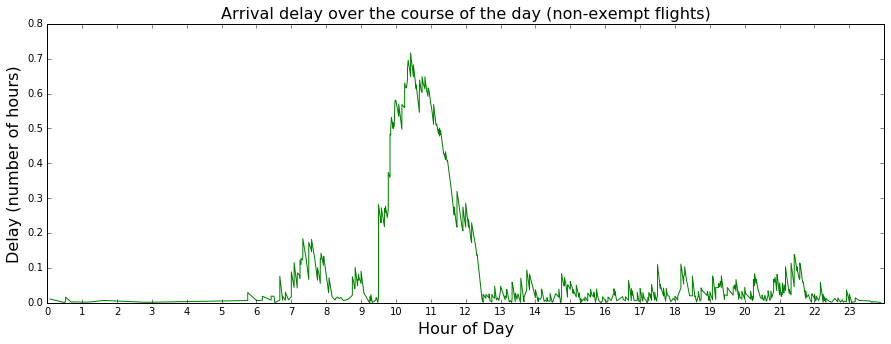

In [44]:
# Plot delays over the course of the day

q7_NE = q7[q7["exempt"] == 0]

plt.figure(figsize=(15,5))
plt.plot( q7_NE["Arrival Time 2"], q7_NE["delay"], 'g-')

plt.xticks(np.arange(0,24,1.0))
plt.xlim(0,24)
plt.xlabel("Hour of Day", fontsize=16)
plt.ylabel("Delay (number of hours)", fontsize=16)
plt.title("Arrival delay over the course of the day (non-exempt flights)", fontsize=16)

plt.show()

In [45]:
print("Total Delay is", "{:.2f}".format(q7.delay.sum()), "hours")

Total Delay is 89.00 hours


### Q7, part B

>The GDP end time is when the airport is expected to catch up with the backlog of
demand created by the low capacity period. Approximately when will this be?

Based on the chart above, it looks like the long period of delay ends between 12:20 and 12:30, so I inspect this range manually. Keep in mind that the chart above only plots delay for non-exempt flights, since delay is practically 0 for exempt flights. 

In [46]:
q7_NE[(q7_NE["Arrival Time 2"] > 12.2) & (q7_NE["Arrival Time 2"] < 12.5)]

,index,CAR,FLNO,EQP,SEATS,ORIGIN,Arrival Time 2,Arrival Time 1,MTOW (000 lbs),ASPEEDF (kts),TYPE,Class,exempt,scheduled,delay
366,591,UA,864,757,188,SAL,12.23,12:14,230.0,139,Boeing 757,B,0,12.422071,0.1921
367,919,WN,598,733,137,OAK,12.25,12:15,124.5,138,Boeing 737,L,0,12.433447,0.1834
369,748,UA3,5228,EM2,30,SAN,12.28,12:17,25.4,113,Embraer 120,S,0,12.444824,0.1648
370,593,UA,2960,733,128,PHX,12.32,12:19,124.5,138,Boeing 737,L,0,12.456200,0.1362
371,387,OE,7019,J31,18,SNA,12.33,12:20,16.0,112,Jetstream Super31,S,0,12.467577,0.1376
373,594,UA,607,320,144,ORD,12.47,12:28,162.0,139,Airbus 320,L,0,12.478953,0.0090
374,242,DL,520,M90,152,TUS,12.48,12:29,156.0,139,Douglas MD 90,L,0,12.490330,0.0103


It looks like UA flight 594 is the first to arrive as scheduled after a long period of delayed arrivals. So I'll say that the GDP end time is approximately __12:30__.

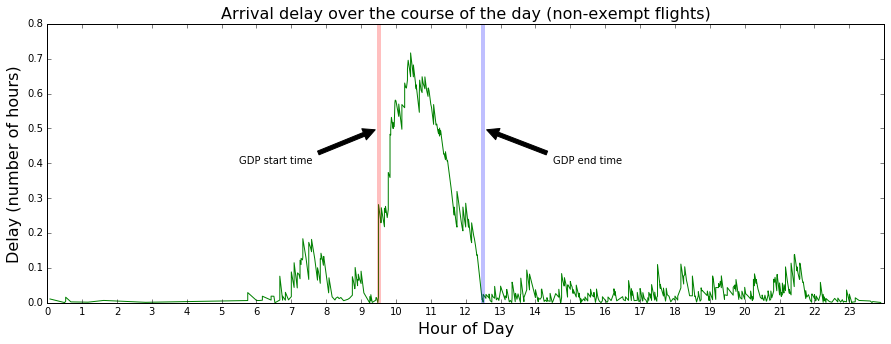

In [47]:
# Plot delays over the course of the day

q7_NE = q7[q7["exempt"] == 0]

plt.figure(figsize=(15,5))
plt.plot( q7_NE["Arrival Time 2"], q7_NE["delay"], 'g-')

plt.xticks(np.arange(0,24,1.0))
plt.xlim(0,24)
plt.xlabel("Hour of Day", fontsize=16)
plt.ylabel("Delay (number of hours)", fontsize=16)
plt.title("Arrival delay over the course of the day (non-exempt flights)", fontsize=16)

plt.axvline(x = 9.5, linewidth = 4, color = 'r', alpha = 0.25)
plt.annotate('GDP start time', xy=(9.5, .5), xytext=(5.5, .4),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

plt.axvline(x = 12.5, linewidth = 4, alpha = 0.25)
plt.annotate('GDP end time', xy=(12.5, .5), xytext=(14.5, .4),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

plt.show()

### Q7, part C

>Now consider only the flights operated by United or its regional carrier (UA or
UA3) during the GDP. Since United “owns” these slots, they can swap the flights
that belong to certain slots. However, the reassigned slot time cannot be earlier
than the original scheduled arrival time. United can also cancel flights to free up
slots for later flights. Select a schedule of arrivals that (approximately) minimizes
the total passenger delay for all United flights. Assume all flights operate at 80%
load factor, and assume that a cancellation is equivalent to 2 hours of flight delay
for each passenger on board the cancelled flight. How much passenger delay is
saved by allowing United to shuffle its flights around? Clearly explain the
procedure or algorithm you use to solve this problem.

For this problem, I first subset the schedule to United or United regional flights only:

In [48]:
united = q7.loc[(q7["CAR"] == "UA") | (q7["CAR"] == "UA3")]

Then I calculate passenger delay for all of these flights, and calculate the total for comparison after switching:

In [49]:
united["paxdelay"] = united.delay * (0.8 * united.SEATS)
print("Total Delay is", "{:.2f}".format(united.paxdelay.sum()), "hours")

Total Delay is 2117.54 hours


C:\Users\pksohn\Anaconda\envs\ipykernel_py3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


The algorithm for switching flights is below. The steps are:
* Select a flight to potentially move up in the schedule
* Identify all possible flights it could switch with (i.e. cannot be scheduled to leave before original arrival time, it cannot "switch with itself")
* For all candidate flights, identify passenger delay reduction if you make the switch (for the selected flight)
* For all candidate flights, identify passenger delay reduction if you make the switch (for the candidate flight)
* Select the switch with the maximum passenger delay reduction
* Repeat the above for all flights affected by GDP

In [50]:
def switch(idx,united):
    
    # create list of flights during GDP
    # temporary dataframe
    df = united[(united["Arrival Time 2"] > 9.5) & (united["Arrival Time 2"] < 12.5)].sort_values("paxdelay", ascending=False)
    
    # store important variables of flight to move up:
    arr = df.loc[idx,"Arrival Time 2"] # original arrival time
    sch = df.loc[idx,"scheduled"] # scheduled arrival time under GDP
    pdl = df.loc[idx,"paxdelay"] # passenger delay
    
    # remove the flight itself from candidate flights:
    df = df[df.index != idx]
    
    # remove flights that are scheduled to arrive earlier than original arrival time
    df = df[df.scheduled > arr]
    
    if len(df) > 0:
        
        # create new dataframe for testing possibilities 
        test = df.copy()
        
        # calculate pax delay savings for selected flight, given each possible switch
        test["idxdelaydiff"] = pdl - ((test.scheduled - arr) * test.SEATS * 0.8)
        
        # set the scheduled arrival for each candidate flight to be the same as for the selected flight
        test["testscheduled"] = sch
        
        # calculate new pax delay (use minimum of 2 hours and calculated delay for each pax)
        test["newpaxdelay"] = test.apply(lambda row: min(2, row.testscheduled - row["Arrival Time 2"]) * row.SEATS * 0.8, axis = 1)
        
        # calculate difference in delay
        test["paxdelaydiff"] = test.paxdelay - test.newpaxdelay
        
        # add up pax delay savings
        test["diff_sum"] = test["paxdelaydiff"] + test["idxdelaydiff"]
        
        # identify the switch with largest savings
        best = test["diff_sum"].max()
        
        # prevent switches that make the situation worse
        if best > 0:
            
            # execute the switch in the original schedule
            switch = test["diff_sum"].argmax()
            switch_sched = test.loc[switch,"scheduled"]
            united.loc[switch, "scheduled"] = sch
            united.loc[idx, "scheduled"] = switch_sched
    
    return united

In [51]:
# get list of flights affected by GDP
gdp = united[(united["Arrival Time 2"] > 9.5) & (united["Arrival Time 2"] < 12.5)].sort_values("paxdelay", ascending=False)

# execute switches
for i in gdp.index.values:
    united = switch(i, united)

C:\Users\pksohn\Anaconda\envs\ipykernel_py3\lib\site-packages\pandas\core\indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [52]:
# recalculate delay

united["delay"] = round(united.scheduled - united["Arrival Time 2"], 4)
united["paxdelay"] = united.delay * (0.8 * united.SEATS)
print("Total Delay is", "{:.2f}".format(united.paxdelay.sum()), "hours")

Total Delay is 1867.31 hours


C:\Users\pksohn\Anaconda\envs\ipykernel_py3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\pksohn\Anaconda\envs\ipykernel_py3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Q7, part C

It turns out that my slot-switching algorithm reduced total passenger delay by about __250 hours__ (2117.54 - 1867.31).